In [ ]:
import os
import json
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

In [10]:
EXTRACT_PATH = "eeg_data"
ZIP_PATH = "eye-state-classification-eeg-dataset.zip"
DATA_FILE = "EEG_Eye_State_Classification.csv"

os.makedirs(EXTRACT_PATH, exist_ok=True)

if not os.path.exists(f"{EXTRACT_PATH}\{DATA_FILE}"):
    with open('kaggle.json', "r") as file:
        config = json.load(file)

    os.environ['KAGGLE_USERNAME'] = config["username"]
    os.environ['KAGGLE_KEY'] = config["key"]

    import kaggle

    !kaggle datasets download -d robikscube/eye-state-classification-eeg-dataset
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
else:
    print("Data exists locally, will not re-download")

Data exists locally, will not re-download


In [11]:
CSV_DATA = f"{EXTRACT_PATH}/{DATA_FILE}"
df = pd.read_csv(CSV_DATA)
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


Number of missing rows per column
AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64


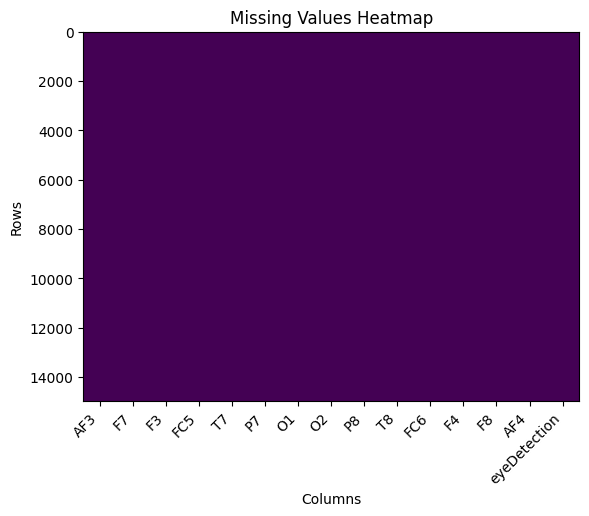

In [13]:
def plot_missing_values(df, TITLE = "Missing Values Heatmap", XLABEL = 'Columns', YLABEL = 'Rows'):
    print("Number of missing rows per column")
    print(df.isnull().sum())
    plt.figure()
    plt.imshow(df.isnull(), cmap='viridis', aspect='auto')
    plt.title(TITLE)
    plt.xlabel(XLABEL)
    plt.ylabel(YLABEL)
    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns, rotation=45, ha='right')
    plt.show()

plot_missing_values(df)

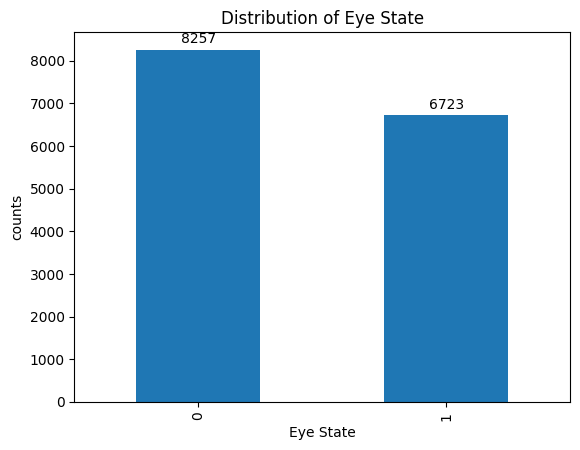

In [14]:
def plot_distribution(df, col = None, x_label = "x_label", y_label = "y_label", title = "title", display_counts = True):
    counts = df[col].value_counts()

    plt.figure()
    ax = counts.plot(kind="bar")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    if display_counts:
        # Add counts on bars
        for i, v in enumerate(counts.values):
            ax.text(i, v + (0.01 * v), str(v), ha='center', va='bottom')

    plt.show()

plot_distribution(df, "eyeDetection", x_label= "Eye State", y_label="counts", title="Distribution of Eye State")

In [15]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score


TARGET_COL = "eyeDetection"
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

TEST_SIZE = 0.25
TRAIN_SIZE = 1 - TEST_SIZE

print(f"Training Size: {TRAIN_SIZE}")
print(f"Testing Size: {TEST_SIZE}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)


Training Size: 0.75
Testing Size: 0.25


In [ ]:
def plot_cm(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    return cm

def plot_ROC(model, X_test, y_test):
    
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_PrecisionRecall(model, X_test, y_test, binary):
    if binary:
        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)

        plt.figure(figsize=(6, 5))
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision–Recall Curve")
        plt.tight_layout()
        plt.show()
    else:
        y_prob = model.predict_proba(X_test)
        for i, cls in enumerate(model.classes_):
            precision, recall, _ = precision_recall_curve(y_test == cls, y_prob[:, i])

            plt.figure(figsize=(6, 5))
            plt.plot(recall, precision)
            plt.title(f"PR Curve – Class {cls}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.tight_layout()
            plt.show()

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 Score: {f1:.3f}")

    # 1. Confusion Matrix
    cm = plot_cm(y_test, y_pred)

    # 2. ROC Curve 
    if len(model.classes_) == 2:
        try:
            plot_ROC(model, X_test, y_test)
        except:
            print("ROC curve skipped (no predict_proba available).")

    
    # 3. Precision–Recall Curve
    try:
        if len(model.classes_) == 2:
            binary = True
            plot_PrecisionRecall(model, X_test, y_test, binary)
            

        else:
            # multi-class: show per-class PR curves
            binary = False
            plot_PrecisionRecall(model, X_test, y_test, binary)
            
    except:
        print("Precision–Recall curve skipped (no predict_proba available).")

    return model, accuracy, f1, cm


def run_grid_search(model, param_grid, X_train, y_train, cv=3):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        verbose=1,
        scoring="f1_weighted"
    )

    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)

    return grid_search.best_estimator_


Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'subsample': 0.8}
Accuracy: 0.869
F1 Score: 0.869


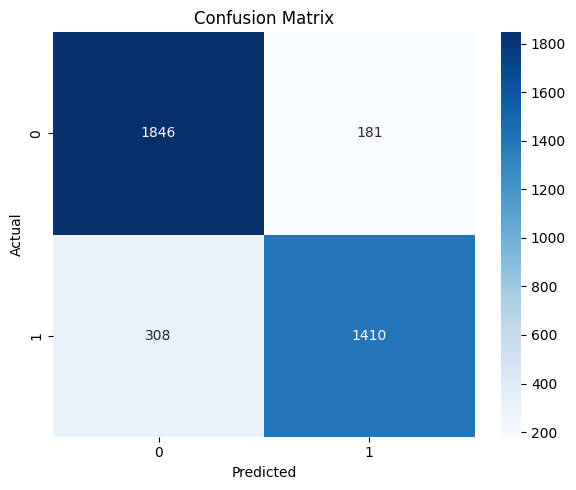

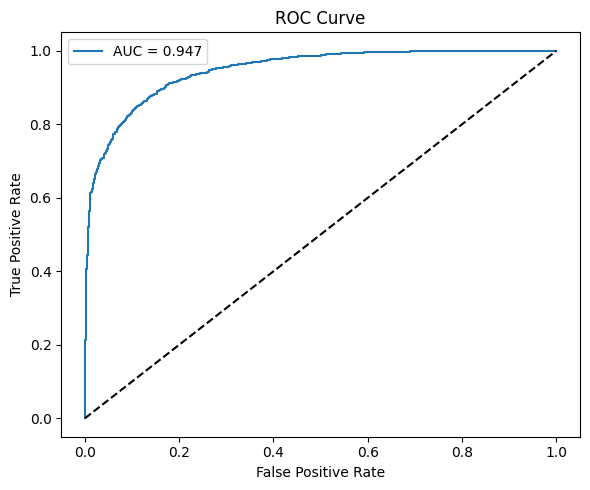

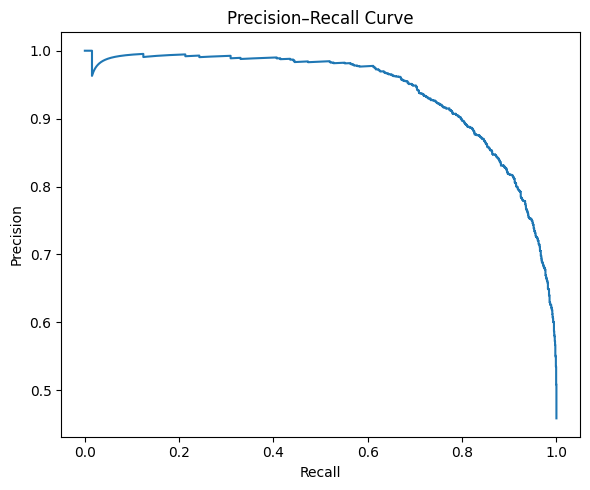

Accuracy: 0.944
F1 Score: 0.944


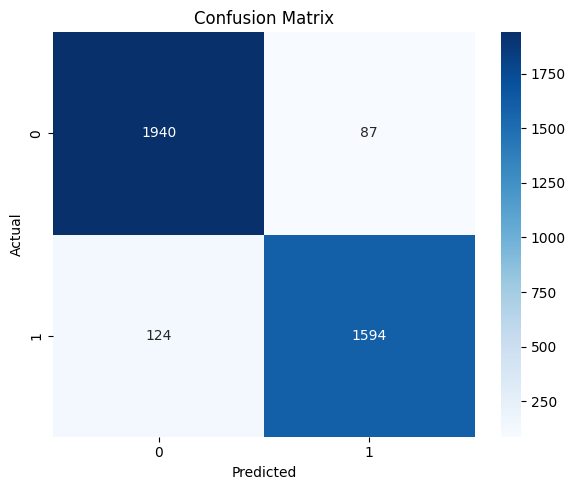

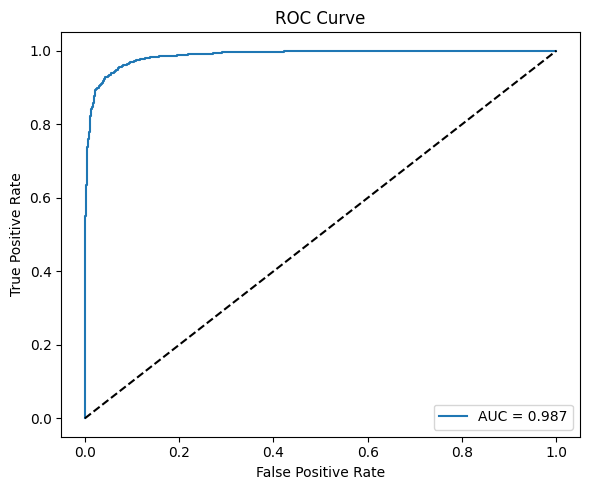

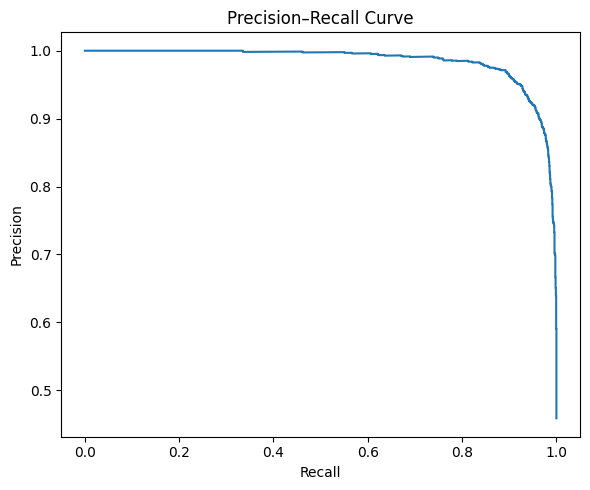

In [17]:
from xgboost import XGBClassifier

# Classification model
model = XGBClassifier(
    objective='binary:logistic',   # or "multi:softprob" for multi-class
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='logloss'
)

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Run grid search
best_model = run_grid_search(model, param_grid, X_train, y_train)

# Evaluate baseline model
my_model, my_accuracy, my_f1, my_cm = evaluate_model(model, X_train, X_test, y_train, y_test)

# Evaluate tuned model
new_model, new_accuracy, new_f1, new_cm = evaluate_model(best_model, X_train, X_test, y_train, y_test)


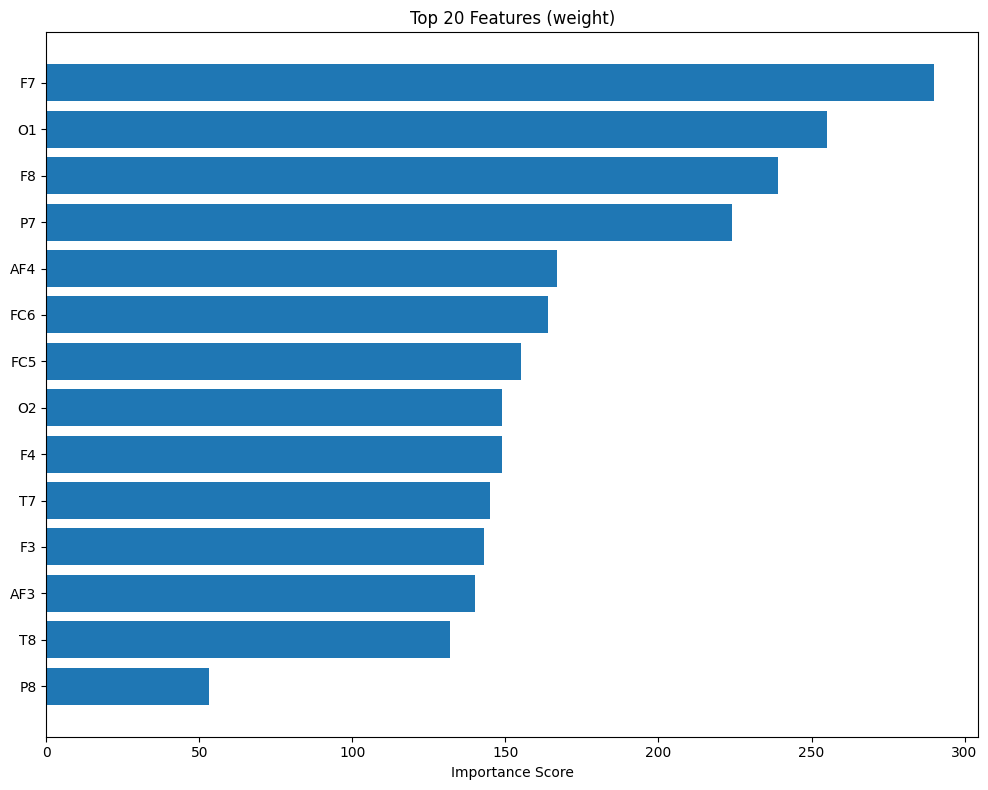

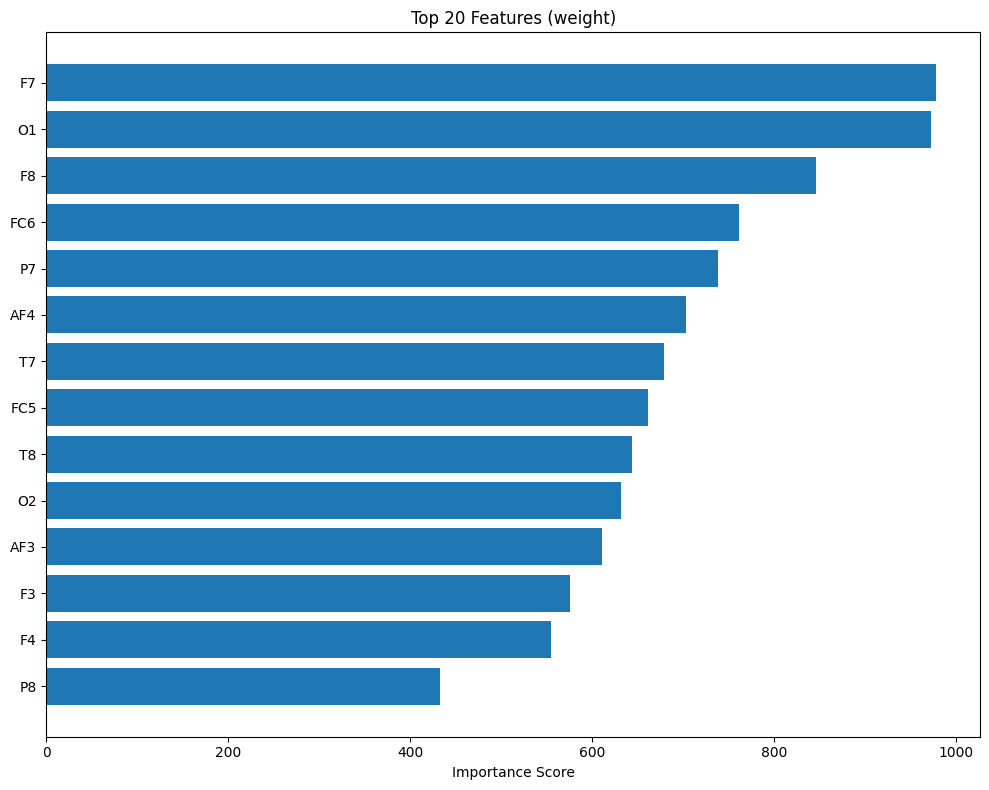

In [18]:
def plot_feature_importance(model, top_n=20, importance_type="weight"):

    booster = model.get_booster()
    importance = booster.get_score(importance_type=importance_type)

    importance_df = (
        pd.DataFrame({
            "Feature": list(importance.keys()),
            "Importance": list(importance.values())
        })
        .sort_values("Importance", ascending=False)
    )

    plt.figure(figsize=(10, 8))
    plt.barh(
        importance_df["Feature"].head(top_n)[::-1],
        importance_df["Importance"].head(top_n)[::-1]
    )
    plt.xlabel("Importance Score")
    plt.title(f"Top {top_n} Features ({importance_type})")
    plt.tight_layout()
    plt.show()

    return importance_df

my_importance_df = plot_feature_importance(my_model, top_n=20)
new_importance_df = plot_feature_importance(new_model, top_n=20)